## Проект по выбору гипотезы и анализу результатов А/В тестирования интернет-магазина

## Описание проекта

Есть список из 9 гипотез по увеличению выручки крупного интернет-магазина. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**Описание данных**

Файл /datasets/hypothesis.csv. 

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv. 

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.  

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Приоритизации гипотез** будет проведена двумя методами:  ICE и RICE. Будут учтены охват пользователей и влияние изменений на них. А также затраты на проверку гипотезы и уверенность в ней. Решение о выборе гипотезы будут принято по результатам обоих методов.

**В ходе анализа А/В теста** будет рассматриваться влияние изменений на рост выручки. 

Для этого рассмотрим влияние на увеличения **значений**: среднее количества заказов на посетителя и средний чек. 

План работы: 
- подготовить данные к анализу
- посторить графики кумулятивных средних значений по группам
- посторить графики относительных изменений средних значений группы А к группе В
- посторить точечные графики  и расчитать 95-й и 99-й перцентили для фильтрации выбросов
- расчитать статистическую значимость различий средних значений для данных с выбросами и без
- сделать вывод по результатам теста

## Импорт библиотек

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

## Приоритизация гипотез

In [2]:
try:
     hypothesis = pd.read_csv(r"D:\Проекты Яндекс.Практикум\DA\02 Проект Принятие решейний в бизнесе\hypothesis.csv")
except: 
     hypothesis = pd.read_csv('/datasets/hypothesis.csv')
        
pd.set_option('max_colwidth', 500)        
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
- Efforts — сколько стоит протестировать эту гипотезу. 

In [3]:
hypothesis['ICE'] = round((hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],2)
hypothesis['RICE'] = round((hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],2)

In [4]:
hypothesis[['Hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [5]:
hypothesis[['Hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**ВЫВОД**

Использовали два метода приоритизации гипотез:
- ICE  - метод, учитывающий влияние, уверенность и усилия
- RICE - метод, учитывающий влияние, уверенность, усилия и охват

По результатам обоих методов в первой тройке оказались гипотезы 7 и 0:
7 = Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
0 = Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Методы показывают разный результат, так как в RICE учитывается скольких пользователей коснется изменение, которое планируем внести. 

По этой причине гипотеза № 8 = "Запустить акцию, дающую скидку на товар в день рождения" спустилась с первого места (ICE) на пятое  (RICE). Вероятно, не все пользователи оставляют данные о днях рождениях в профиле. Соответсвенно, не все смогут пользоваться привилегиями акции.

В итоге рекомендуется тестировать гипотезу № 7. Она значительно вырвалась вперед при оценке методом RICE и заняло третье место с небольшим отрывом в методе ICE



## Анализ A/B-теста

### Загрузка данных

In [6]:
try:
     orders = pd.read_csv(r"D:\Проекты Яндекс.Практикум\DA\02 Проект Принятие решейний в бизнесе\orders.csv")
except: 
     orders = pd.read_csv('/datasets/orders.csv')  

print('Первые пять строк')
display(orders.head())
print('')
print('Общая информация')
display(orders.info())
print('')
print('Количество явных дубликатов:', orders.duplicated().sum())

Первые пять строк


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None


Количество явных дубликатов: 0


In [7]:
orders['date'] = orders['date'].astype('datetime64[ns]')

In [8]:
try:
     visitors = pd.read_csv(r"D:\Проекты Яндекс.Практикум\DA\02 Проект Принятие решейний в бизнесе\visitors.csv")
except: 
     visitors = pd.read_csv('/datasets/visitors.csv')
        
print('Первые пять строк')
display(visitors.head())
print('')
print('Общая информация')
display(visitors.info())
print('')
print('Количество явных дубликатов:', visitors.duplicated().sum())        

Первые пять строк


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None


Количество явных дубликатов: 0


In [9]:
visitors['date'] = visitors['date'].astype('datetime64[ns]')

### 1. Построение графика кумулятивной выручки по группам

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


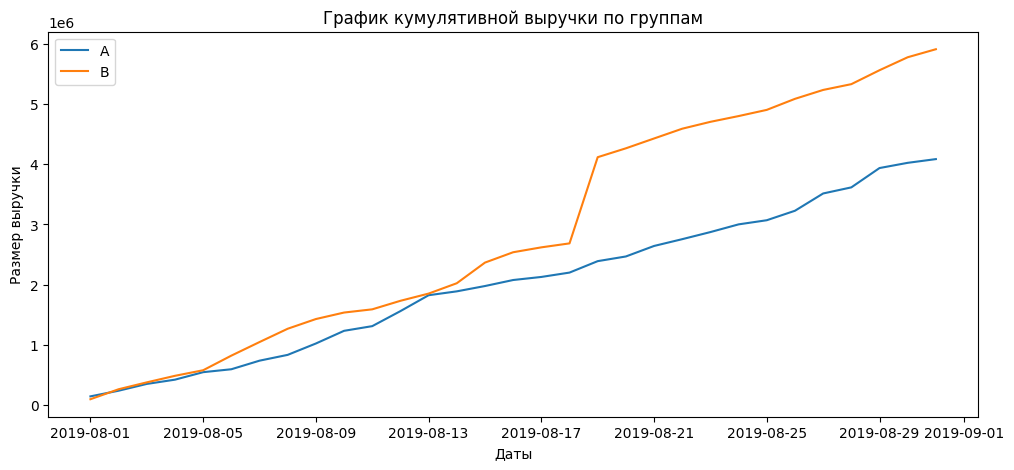

In [11]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Даты')
plt.ylabel('Размер выручки')
plt.title('График кумулятивной выручки по группам')
plt.legend() 
plt.show()

**ВЫВОД**

Из графика видно, что тестирование продолжалось один месяц. Куммулятивная выручка в обеих группах стабильно росла. Примерно с середины эксперимента выручка по группе В стала показывать лучшие результаты, чем выручка по группе А.
Любопытно, что в районе 18 августа произошел резкий подъем по группе В. Это может говорить о выбросах в этот день, проверим в дальнейшем

### 2. Построение графика кумулятивного среднего чека по группам

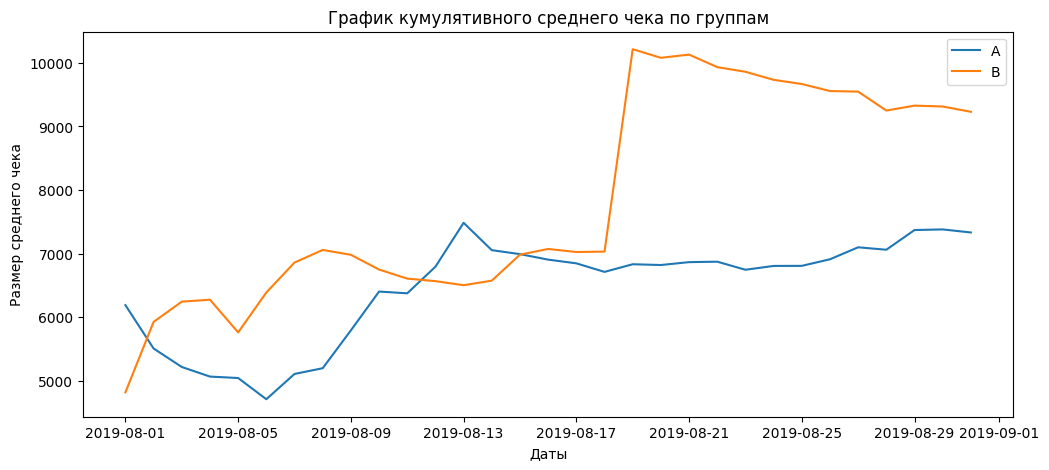

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xlabel('Даты')
plt.ylabel('Размер среднего чека')
plt.title('График кумулятивного среднего чека по группам')
plt.legend() 
plt.show()

**ВЫВОД** 

Аналогично предыдущему графику средний чек по группе В резко выро с районе 18 августа. 
В целом средний чек по обеим группам рос. Есть разнонаправленное колебание в районе 13 августа, когда по группе А - средний чек вырос, а по группе В наоборот снизился

### 3. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

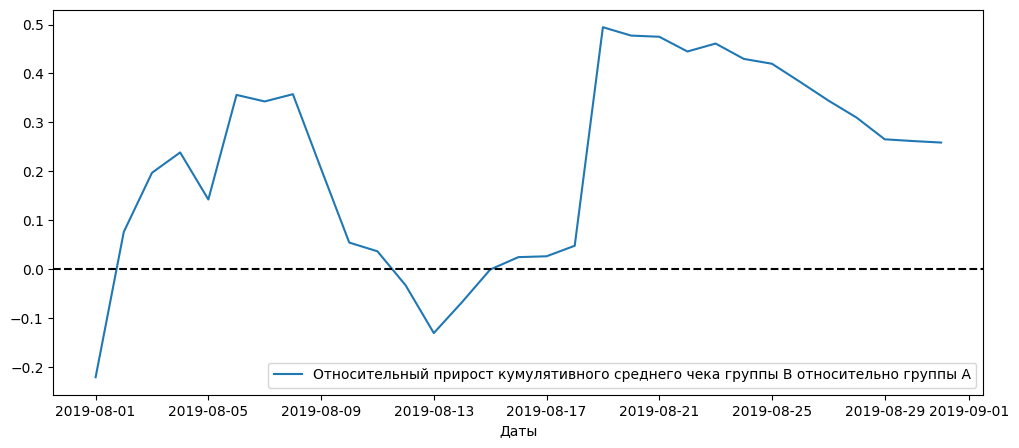

In [13]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, label="Относительный прирост кумулятивного среднего чека группы B относительно группы A")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.xlabel('Даты')
plt.legend()
plt.show()

**ВЫВОД**

По графику относительного изменения кумулятивного среднего чека группы B к группе А  группа В показывает положительную динамикую. Да, есть падение в районе 13 августа. Но большую часть эксперимента средний чек по группе В лидирует относительно среднего чека по группе А.
 
На этом и предыдущих графиках не учтены выбросы, поэтому выводы предварительные 

### 4. Построение графика кумулятивного среднего количества заказов на посетителя по группам.

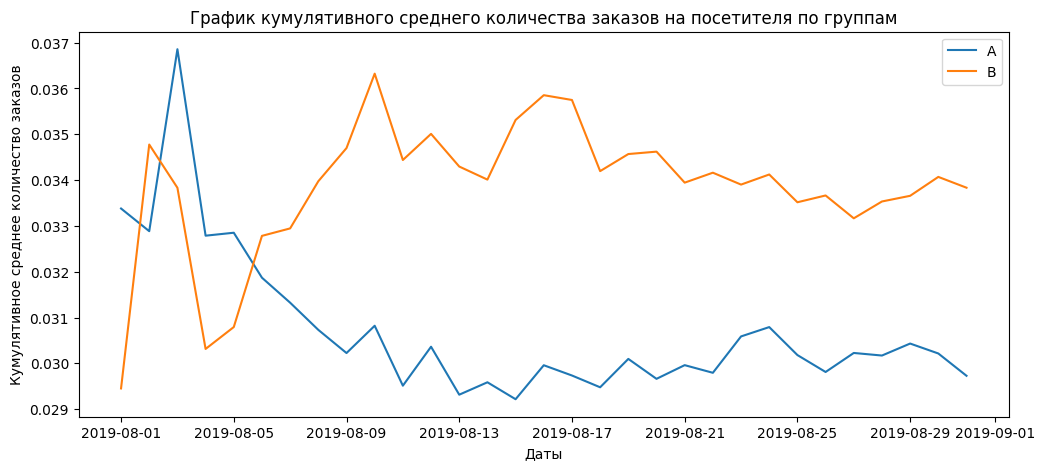

In [14]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xlabel('Даты')
plt.ylabel('Кумулятивное среднее количество заказов')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.legend() 
plt.show()

**ВЫВОД**

Кумулятивное среднее количество заказов у группы B сталбильно выше, чем у группы А после первой недели эксперимента. 

### 5. Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

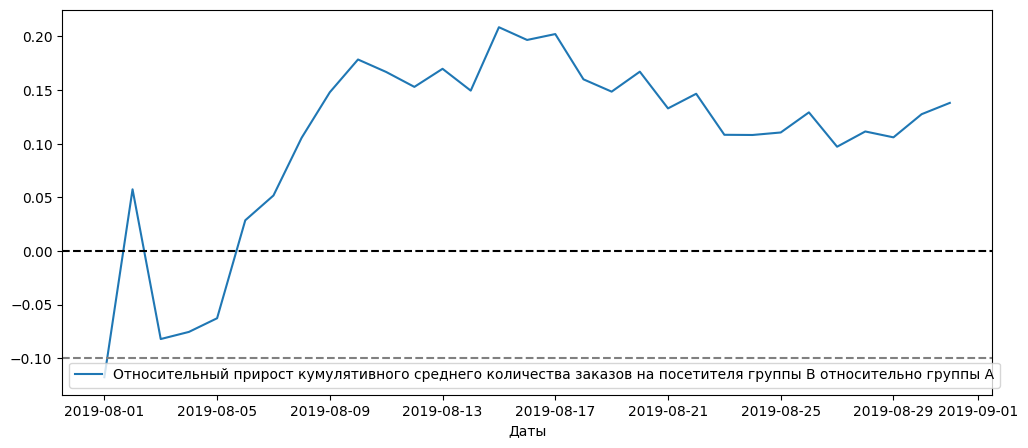

In [15]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.xlabel('Даты')
plt.legend()
plt.show()

**ВЫВОД**

На этом графике также видно, что после первой недели эксперимента относительный прирост кумулятивного среднего количества заказов на посетителя группы В относительно группы А становится положительным. И больше не снижается до нуля

### 6. Построение точечного графика количества заказов по пользователям

In [16]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


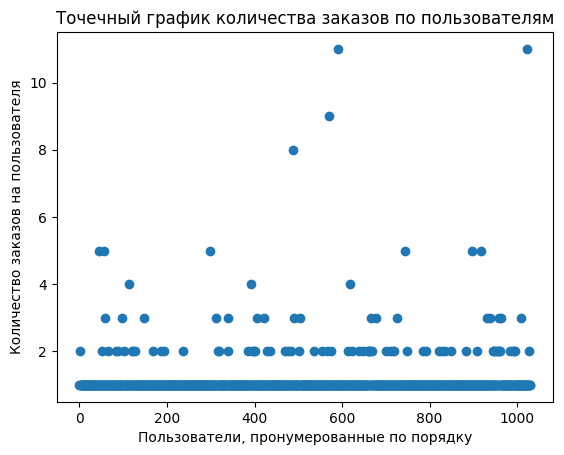

In [17]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 

plt.xlabel('Пользователи, пронумерованные по порядку')
plt.ylabel('Количество заказов на пользователя')
plt.title('Точечный график количества заказов по пользователям')
plt.show()

**ВЫВОД**

На точечном графике видно, что большинство пользователей делают 1 заказ, также много пользователей делает 2 заказа. Небольшое количество активных пользователей делают около 10 заказов в течение эксперимента.

### 7. Подсчет 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [18]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


**ВЫВОД**

Подсчет перцентилей показал, что не более 5% пользователей делают больше 2 заказаов, не более 1 % пользователей делают больше 4 заказа. Для дальнейшего анализа отбросим всё, что выше 3 заказов. Оставим пользователей, которые делают 1-2 заказа

### 8. Построение точечного графика стоимостей заказов.

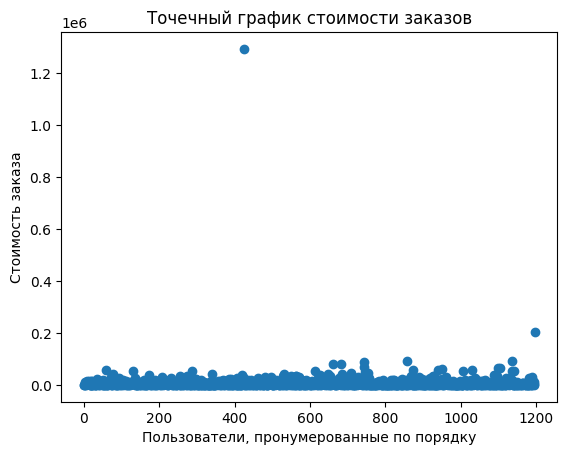

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 

plt.xlabel('Пользователи, пронумерованные по порядку')
plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимости заказов')
plt.show()

**ВЫВОД**

Самый ощутимый выброс - аномальный заказ стоиомостью около 1 200 000.  На графике, даже при увеличении масштаба, плохо видно, какая стоимость заказа наиболее типичная. Рассмиотрим внимательнее при расчете перцентилей.

### 9. Посдсчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [20]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


**ВЫВОД**

Не более 5 % заказов стоимостью выше 28 000. Не более 1% заказов стоимостью выше 58 000. Отбросим всех, чьи заказы больше 28 000.

### 10. Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Проверка гипотезы:  **Есть различия в выручке полученной от пользователей группы А и группы В**

 
H_0: Различий в выручке между группами нет

H_a: Различия  в выручке между группами есть

alpha = 0.05
 

In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

In [22]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05


print('p_value: ' "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

if stats.mannwhitneyu(sampleA, sampleB)[1] < alpha:
    
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('Относительный припрост в среднем количестве заказов группы В к группе А: 'f"{(sampleB.mean() / sampleA.mean() - 1):.1%}")


p_value: 0.017
Отвергаем нулевую гипотезу
Относительный припрост в среднем количестве заказов группы В к группе А: 13.8%


**ВЫВОД**

Посчитали статистическую значимость различий в среднем количестве заказов на посетителя между группами по **«сырым»** данным

p-value меньше alpha, значит можем отвергнуть нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет. Различия есть.

Относительный прирост в среднем количестве заказов группы В относительно группы А составляет 13,8%


### 11. Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

In [23]:
print('p_value: ' '{0:.2f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

if stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < alpha:
    
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('Относительный припрост среднего чека по группе В к группе А: 'f"{(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1):.1%}")


p_value: 0.73
Не получилось отвергнуть нулевую гипотезу
Относительный припрост среднего чека по группе В к группе А: 25.9%


**ВЫВОД**

Посчитали статистическую значимость различий в среднем чеке между группами по **"сырым"** данным. p-value = 0.73, то есть больше чем, alpha. Не можем отвергнуть нулевую гипотезу об отсутствии различий в среднем чеке.  

При этом относительный прирост среднего чека по группе В относительно группы А составил 26%

### 12. Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [24]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
74


In [25]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [26]:
print('p_value: ' "{0:.2f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

if  (stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]) < alpha:
    
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('Относительный припрост количества заказов по пользователям группы В к группе А: 'f"{(sampleBFiltered.mean()/sampleAFiltered.mean()-1):.1%}")


p_value: 0.01
Отвергаем нулевую гипотезу
Относительный припрост количества заказов по пользователям группы В к группе А: 17.3%


**ВЫВОД**

Посчитали статистическую значимость различий в среднем количестве заказов между группами по отфильтрованным данным. Данным, которые очистили от выбросов.

Как и при расчете по сырым данным p-value меньше alpha , то есть можем отвергнуть нулевую гипотезу об отсутствии различий в среднем количестве заказов. Различия есть.

Относительный прирост количества заказов на пользователи составляет 17%

Убрав аномальные значения, получили более высокий прирост среднего количеста заказов 

### 13. Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

In [27]:
p_value = (
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )

growth = (orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1)
print('p_value: ' 
    '{0:.2f}'.format(p_value))


if  p_value < alpha:
    
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

print('Относительный прирост среднего чека группы В к группе А:' f"{growth :.1%}")

 

p_value: 0.74
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы В к группе А:-2.0%


**ВЫВОД**

После очистки данных от выбросов посчитали статистическую значимость среднего чека между группами. 

p-value по прежнему больше, чем alpha. Не можем отвергнуть нулевую гипотезу об отсутствии различий в среднем чеке. 

Однако после очистки данных иначе повел себя относительный прирост среднего чека группы В к группе А. Стал отрицательным и составил -2%

Можно предположить, что аномальный заказ стоимость 1 200 000 внес изменения в средний чек. При это среднее количество заказов на пользователя изменилось не сильно

### 14. Решение по результатам теста  

Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**ВЫВОД**

Однозначно тест можно остановить. За время теста показатели стабилизировались и по ним можно было судить. 

Кажется, что по результатам теста увеличилось среднее количество заказов на пользователя. При этом не увеличился средний чек. Что же-  прирост количества заказов все равно влияет на выручку. Можно зафиксировать победу. Тем не менее, лучшим результатом теста было бы и увеличение среднего чека. 

К сожалению, неизвестно какая именно гипотеза тестировалась, чтобы дать более конкретные рекомендации.